In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
%matplotlib inline

def Toy (Years=[2015], nBins = 20, SidDay = timedelta(hours = 23,minutes = 56,seconds = 4.091),
         Variance = False,seed = None,Mode=1,fit = True,savename = ''):
    Data = pd.DataFrame({'A' : []})
    for n in range(0,len(Years)):
        year = Years[n]
        name = 'Data/' + str(year) + '_blinded'
        Input = pd.read_csv('%s.csv' % name, sep=',',header=0)
        Data = pd.concat([Data,Input],sort=True)
    
    LIVFedCS = 0.01e-34
    FedCS = 7.5e-34
    
    Lum = 1e34
    LiveTime = np.array(Data.LBLive)
    IntLum = Lum * LiveTime #* 1e33 # x10^33 cm^-2


    Mask = (IntLum != 0) & (LiveTime != 0)
    IntLum = IntLum[Mask]
    Start = np.array(Data.LBStart)[Mask]
    Finish = np.array(Data.LBEnd)[Mask]



    SidDay_Full = timedelta(hours = 23,minutes = 56,seconds = 4.091)
    t_0 = datetime(2000,3,20,11,35,24)
    t_L = datetime(1970,1,1,0,0,0)
    shift = t_0 - t_L
    BlockTimeSCF = Start - shift.total_seconds()
    StartAngle = 2*np.pi*(BlockTimeSCF%SidDay.total_seconds())/SidDay.total_seconds()
    StartAngle_Gen = 2*np.pi*(BlockTimeSCF%SidDay_Full.total_seconds())/SidDay_Full.total_seconds()


    ExpN_z = (IntLum * FedCS)
    ExpN_z_LIV = (IntLum * LIVFedCS)* np.sin(StartAngle_Gen)
    np.random.seed(seed)
    
    if Mode == 1:
        ExpN_z = ExpN_z + ExpN_z_LIV
    if Variance == True:
        ExpN_z = np.random.poisson(ExpN_z)#np.random.normal(ExpN_z, np.mean(ExpN_z)*0.007, len(ExpN_z)) # #
        


    Bins = np.linspace(0,2*np.pi,nBins+1)
    def Binner(Bins,xData,H_Data):
        HeightVal = []
        for n in range(len(Bins)-1):
            if n != nBins-1:
                Mask = (Bins[n] <= xData) & (xData < Bins[n+1])
            else:
                Mask = (Bins[n] <= xData) & (xData <= Bins[n+1])
            
            HeightVal += [np.sum(H_Data[Mask])]
        return np.array(HeightVal)


    dr = True
    if dr == True:

        Ratio1 = Binner(Bins,StartAngle,ExpN_z)/Binner(Bins,StartAngle,IntLum)
        
        Ratio2 = np.sum(Binner(Bins,StartAngle,ExpN_z))/np.sum(Binner(Bins,StartAngle,IntLum))

 
        
        double_ratio = (Ratio1/Ratio2)-1
        HeightArr = double_ratio 
        HeightErr = ((np.sqrt(Binner(Bins,StartAngle,ExpN_z))/Binner(Bins,StartAngle,IntLum))/Ratio2)#/4
        
        N_T = float(np.sum(Binner(Bins,StartAngle,ExpN_z)))
        N_i = np.ones(nBins)
        for n in range(nBins):
            N_i[n] = float(Binner(Bins,StartAngle,ExpN_z)[n])
        N_x = N_T - N_i
        L_i_o_L_T =  Binner(Bins,StartAngle,IntLum)/np.sum(Binner(Bins,StartAngle,IntLum))
        HeightErr = (1/N_T**2 * np.sqrt( N_i *N_T**2  + N_i**2 * (N_i + N_x)))/L_i_o_L_T

            
    for k in range(0,len(HeightErr)):
        if np.isnan(HeightErr[k]) == True:
            print(HeightErr[k])



    Spread = ((np.absolute(np.min(HeightArr))+np.absolute(np.max(HeightArr)))/2)/400
    points = np.zeros(len(Bins)-1)
    for n in range(0,len(Bins)-1):
        points[n] = (Bins[n+1]+Bins[n])/2 

    
    from scipy.optimize import least_squares

    def modfunc(p,x):
        return p[0]*np.sin(x) + p[1]*np.cos(x)

    def fitError(p, x, y, yerr):
        '''
        Error function for quadratic fit
        '''
        e = (y - modfunc(p, x))/(yerr)
        return e

    if fit == True:
        xData = points
        yData = HeightArr
        yError = HeightErr


        nPars = 2
        pInit = [0.0001,0.0001]
        out = least_squares(fitError, pInit, args=(xData, yData, yError))

        fitOK = out.success

        # Test if fit failed
        if not fitOK:
            print(" ")
            print("Fit failed")
        else:
            pFinal = out.x
            p0Val = pFinal[0]
            p1Val = pFinal[1]

            #   Calculate chis**2 per point, summed chi**2 and chi**2/NDF
            chiarr = fitError(pFinal, xData, yData, yError)**2
            chisq = np.sum(chiarr)
            NDF = nBins - nPars
            redchisq = chisq/NDF

            np.set_printoptions(precision = 3)
            print(" ")
            print("Fit quality:")
            #print("chisq per point = \n",chiarr)
            print("chisq = {:5.2f}, chisq/NDF = {:5.2f}.".format(chisq, redchisq))
            jMat = out.jac
            jMat2 = np.dot(jMat.T, jMat)
            detJmat2 = np.linalg.det(jMat2)
            #
            if detJmat2 < 1E-32:
                print("Value of determinat detJmat2",detJmat2)
                print("Matrix singular, error calculation failed.")
                print(" ")
                print("Parameters returned by fit:")
                print("p0 = {}".format(p0Val))
                print("p1 = {}".format(p1Val))
                print(" ")
            else:
                covar = np.linalg.inv(jMat2)
                p0Err = np.sqrt(covar[0, 0])
                p1Err = np.sqrt(covar[1, 1])
                print(" ")
                print("Parameters returned by fit:")
                print("p0 = {} +- {}".format(p0Val, p0Err))
                print("p1 = {} +- {}".format(p1Val, p1Err))
                print(" ")

        xfit = np.linspace(0,2*np.pi,1000)
        yfit = modfunc([p0Val,p1Val],xfit)
    
    fig = plt.figure(figsize = (10, 7))
    if Mode == 1:
        modename = 'LIV Signal'
    if Mode == 0:
        modename = 'Null Signal'
    plt.title('{}, {} Bin, {:.4} Hour Sidereal Day'.format(modename,nBins,SidDay.total_seconds()/3600))
    if fit == True:
        plt.plot(xfit,yfit,color='r',label='fit',linewidth = 4)
    plt.errorbar(points,HeightArr,yerr = HeightErr,linestyle=' ',marker='o',label='Data')
    #plt.ylim(np.mean(HeightArr)-Spread,np.mean(HeightArr)+Spread)
    ylim = 0.005
    plt.ylim(-ylim,ylim)
    plt.xlabel('Sidereal Phase / Radians')
    plt.ylabel('Double Ratio')
    plt.legend()
    if (not savename) == False:
        plt.savefig(savename, dpi=300)
    plt.show()
    

 
Fit quality:
chisq = 101.88, chisq/NDF =  1.04.
 
Parameters returned by fit:
p0 = 0.001247340098002547 +- 0.00012656910336155064
p1 = -0.00022432275371492389 +- 0.00012639692185803373
 


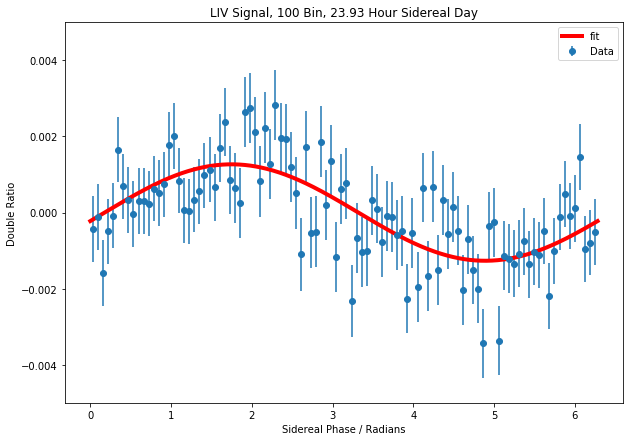

In [17]:
Toy([2015,2016,2017,2018],nBins = 100,Variance = True,seed = 901, Mode=1, savename = r'thesis template\figures\LIVSignal.png')


 
Fit quality:
chisq = 88.31, chisq/NDF =  0.90.
 
Parameters returned by fit:
p0 = -9.49695092567834e-05 +- 0.0001264641797445752
p1 = -0.00015574098405426358 +- 0.00012647841327345966
 


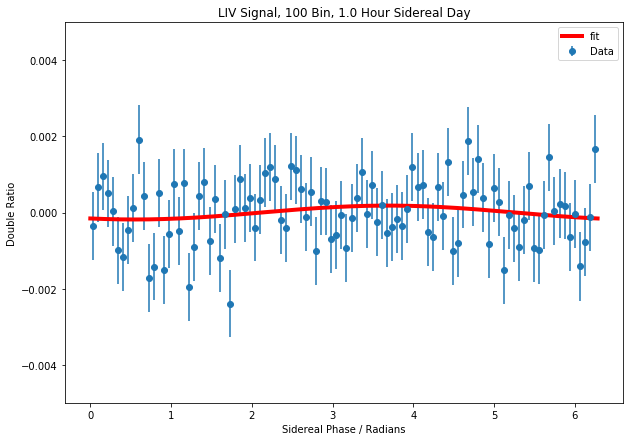

In [80]:
Toy([2015,2016,2017,2018],SidDay = timedelta(hours=1),seed = 901,Variance = True,nBins = 100,Mode=1,savename = r'thesis template\figures\OneHourSignal.png')

 
Fit quality:
chisq = 72.82, chisq/NDF =  0.74.
 
Parameters returned by fit:
p0 = -9.970824978576667e-05 +- 0.00012656400816424
p1 = -5.04667020148903e-05 +- 0.00012639492888147155
 


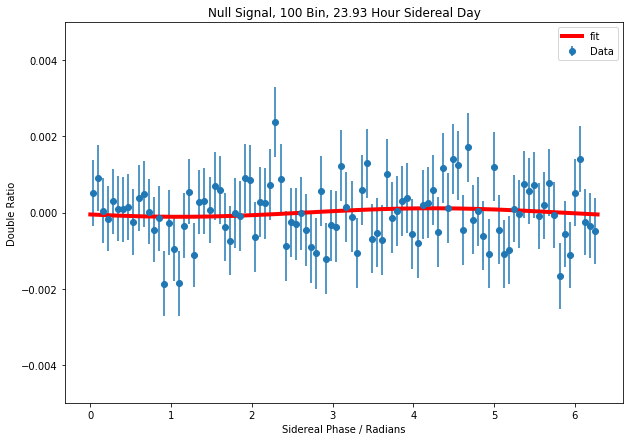

In [63]:
Toy([2015,2016,2017,2018],nBins = 100,Variance = True,seed = 0, Mode=0, savename = r'thesis template\figures\NullSignal.png')

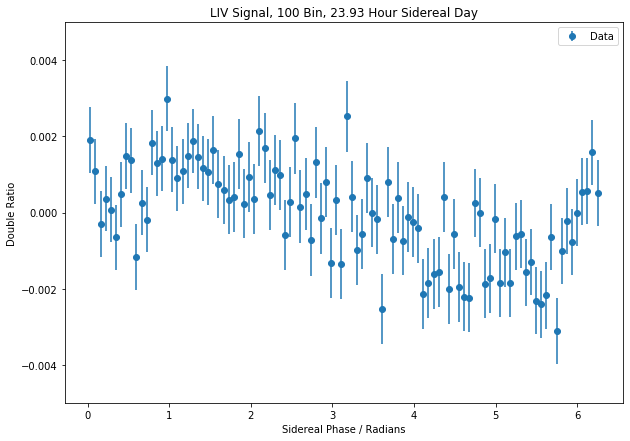

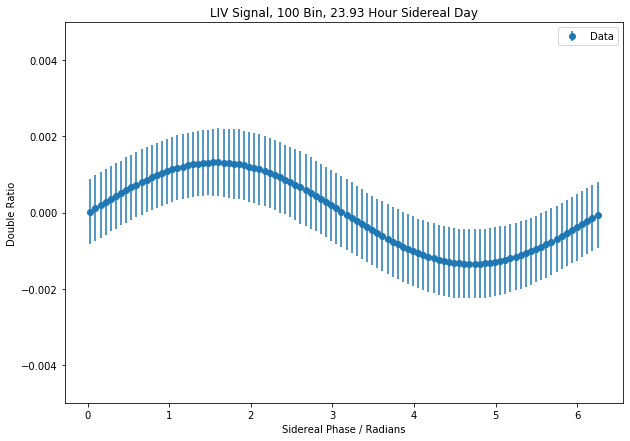

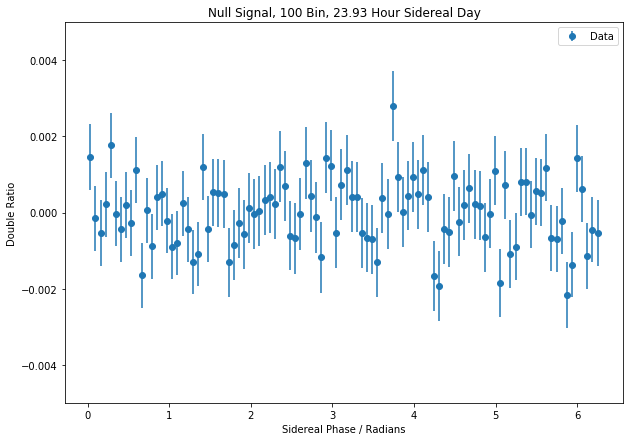

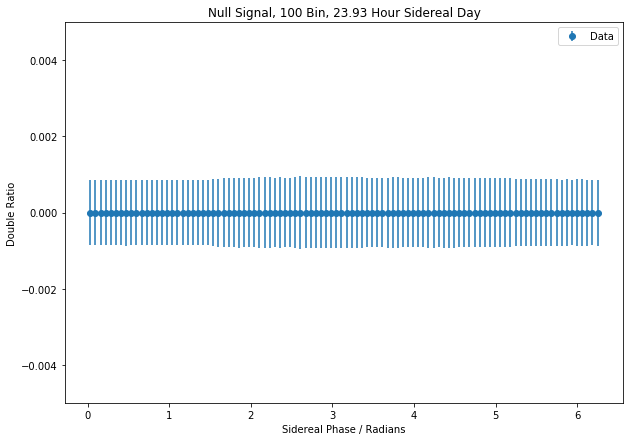

In [19]:
Toy([2015,2016,2017,2018],nBins = 100,Variance = True,seed = 91, Mode=1, savename = r'thesis template\figures\LIVSignal_nofit.png',fit = False)
Toy([2015,2016,2017,2018],nBins = 100,Variance = False,seed = 91, Mode=1, savename = r'thesis template\figures\LIVSignal_nofit_novar.png',fit = False)

Toy([2015,2016,2017,2018],nBins = 100,Variance = True,seed = 1, Mode=0, savename = r'thesis template\figures\NullSignal_nofit.png',fit=False)
Toy([2015,2016,2017,2018],nBins = 100,Variance = False,seed = 1, Mode=0, savename = r'thesis template\figures\NullSignal_nofit_novar.png',fit=False)

In [37]:
def Toys (Years=[2015], nBins = 100,nToys = 1, SidDay = timedelta(hours = 23,minutes = 56,seconds = 4.091),
         Variance = False,seed = None,Mode=1):
    Data = pd.DataFrame({'A' : []})
    for n in range(0,len(Years)):
        year = Years[n]
        name = 'Data/' + str(year) + '_blinded'
        Input = pd.read_csv('%s.csv' % name, sep=',',header=0)
        Data = pd.concat([Data,Input],sort=True)
    
    LIVFedCS = 0.01e-34
    FedCS = 7.5e-34
    
    Lum = 1e34
    LiveTime = np.array(Data.LBLive)
    IntLum = Lum * LiveTime #* 1e33 # x10^33 cm^-2


    Mask = (IntLum != 0) & (LiveTime != 0)
    IntLum = IntLum[Mask]
    Start = np.array(Data.LBStart)[Mask]
    Finish = np.array(Data.LBEnd)[Mask]



    SidDay_Full = timedelta(hours = 23,minutes = 56,seconds = 4.091)
    t_0 = datetime(2000,3,20,11,35,24)
    t_L = datetime(1970,1,1,0,0,0)
    shift = t_0 - t_L
    BlockTimeSCF = Start - shift.total_seconds()
    StartAngle = 2*np.pi*(BlockTimeSCF%SidDay.total_seconds())/SidDay.total_seconds()
    StartAngle_Gen = 2*np.pi*(BlockTimeSCF%SidDay_Full.total_seconds())/SidDay_Full.total_seconds()


    ExpN_z = (IntLum * FedCS)
    ExpN_z_LIV = (IntLum * LIVFedCS)* np.sin(StartAngle_Gen)
    if Mode == 1:
        ExpN_z = ExpN_z + ExpN_z_LIV    
    

    Bins = np.linspace(0,2*np.pi,nBins+1)
    def Binner(Bins,xData,H_Data):
        HeightVal = []
        for n in range(len(Bins)-1):
            if n != nBins-1:
                Mask = (Bins[n] <= xData) & (xData < Bins[n+1])
            else:
                Mask = (Bins[n] <= xData) & (xData <= Bins[n+1])
            
            HeightVal += [np.sum(H_Data[Mask])]
        return np.array(HeightVal)
    
    
    p0_Arr = []
    p1_Arr = []
    chi_pdf = []
    p0Err_Arr = []
    p1Err_Arr = []
    
    def modfunc(p,x):
        return p[0]*np.sin(x) + p[1]*np.cos(x)

    def fitError(p, x, y, yerr):
        e = (y - modfunc(p, x))/(yerr)
        return e

    np.random.seed(seed)
    seeds = np.random.random(size=nToys)
    for toy in range(0,nToys):
        np.random.seed(int(seeds[toy]*1000))
        if Variance == True:
            ExpN_z = np.random.poisson(ExpN_z)

        dr = True
        if dr == True:

            Ratio1 = Binner(Bins,StartAngle,ExpN_z)/Binner(Bins,StartAngle,IntLum)

            Ratio2 = np.sum(Binner(Bins,StartAngle,ExpN_z))/np.sum(Binner(Bins,StartAngle,IntLum))



            double_ratio = (Ratio1/Ratio2)-1
            HeightArr = double_ratio 
            HeightErr = ((np.sqrt(Binner(Bins,StartAngle,ExpN_z))/Binner(Bins,StartAngle,IntLum))/Ratio2)#/4

            N_T = float(np.sum(Binner(Bins,StartAngle,ExpN_z)))
            N_i = np.ones(nBins)
            for n in range(nBins):
                N_i[n] = float(Binner(Bins,StartAngle,ExpN_z)[n])
            N_x = N_T - N_i
            L_i_o_L_T =  Binner(Bins,StartAngle,IntLum)/np.sum(Binner(Bins,StartAngle,IntLum))
            HeightErr = (1/N_T**2 * np.sqrt( N_i *N_T**2  + N_i**2 * (N_i + N_x)))/L_i_o_L_T


        points = np.zeros(len(Bins)-1)
        for n in range(0,len(Bins)-1):
            points[n] = (Bins[n+1]+Bins[n])/2 


        from scipy.optimize import least_squares

        xData = points
        yData = HeightArr
        yError = HeightErr

        nPars = 2
        pInit = [0.0001,0.0001]
        out = least_squares(fitError, pInit, args=(xData, yData, yError))
        fitOK = out.success
        if not fitOK:
            print(" ")
            print("Fit failed")
        else:
            pFinal = out.x
            p0Val = pFinal[0]
            p1Val = pFinal[1]

            chiarr = fitError(pFinal, xData, yData, yError)**2
            chisq = np.sum(chiarr)
            NDF = nBins - nPars
            redchisq = chisq/NDF
            jMat = out.jac
            jMat2 = np.dot(jMat.T, jMat)
            detJmat2 = np.linalg.det(jMat2)
            if detJmat2 < 1E-32:
                print("Value of determinat detJmat2",detJmat2)
                print("Matrix singular, error calculation failed.")
                p0Err = 0
                p1Err = 0
            else:
                covar = np.linalg.inv(jMat2)
                p0Err = np.sqrt(covar[0, 0])
                p1Err = np.sqrt(covar[1, 1])


        p0_Arr += [p0Val]
        p1_Arr += [p1Val]
        p0Err_Arr += [p0Err]
        p1Err_Arr += [p1Err]
        chi_pdf += [redchisq]
    
    return p0_Arr,p1_Arr,p0Err_Arr,p1Err_Arr,chi_pdf


SyntaxError: invalid syntax (<ipython-input-37-623cbbf375bf>, line 143)

In [4]:
p0_Arr,p1_Arr,p0Err_Arr,p1Err_Arr,chi_pdf = Toys([2015,2016,2017,2018],nToys = 1000,Variance = True,seed = 91, Mode=0)
#Null Signal

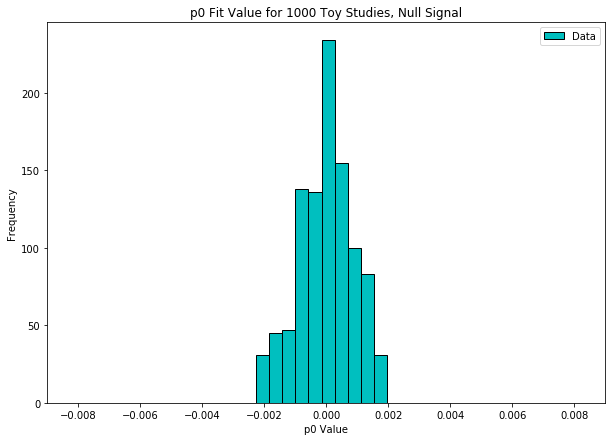

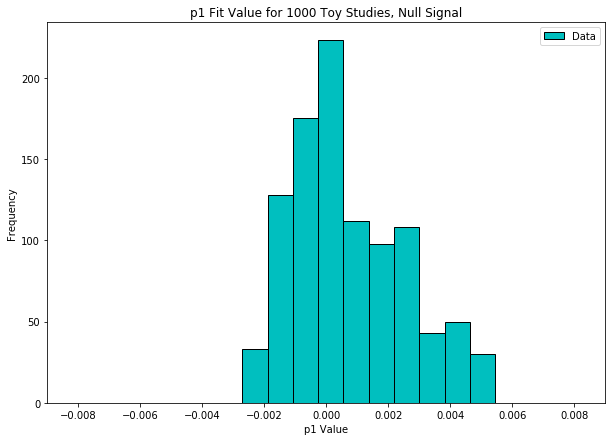

In [26]:
xscale = 0.009


fig = plt.figure(figsize = (10, 7))
nBin = 10
plt.title('p0 Fit Value for 1000 Toy Studies, Null Signal')
plt.ylabel('Frequency')
plt.xlabel('p0 Value')
plt.hist(p0_Arr,bins=nBin,color='c',edgecolor='black',linewidth=1,label='Data')
plt.xlim(-xscale,xscale)
plt.legend()
plt.savefig(r'thesis template\figures\Nullp0Values.png', dpi=300)




fig = plt.figure(figsize = (10, 7))
nBin = 10
plt.title('p1 Fit Value for 1000 Toy Studies, Null Signal')
plt.ylabel('Frequency')
plt.xlabel('p1 Value')
plt.hist(p1_Arr,bins=nBin,color='c',edgecolor='black',linewidth=1,label='Data')
plt.xlim(-xscale,xscale)
plt.legend()
plt.savefig(r'thesis template\figures\Nullp1Values.png', dpi=300)

In [5]:
p0_Arr2,p1_Arr2,p0Err_Arr2,p1Err_Arr2,chi_pdf2 = Toys([2015,2016,2017,2018],nToys = 1000,Variance = True,seed = 0, Mode=1)
#LIV Signal

1000


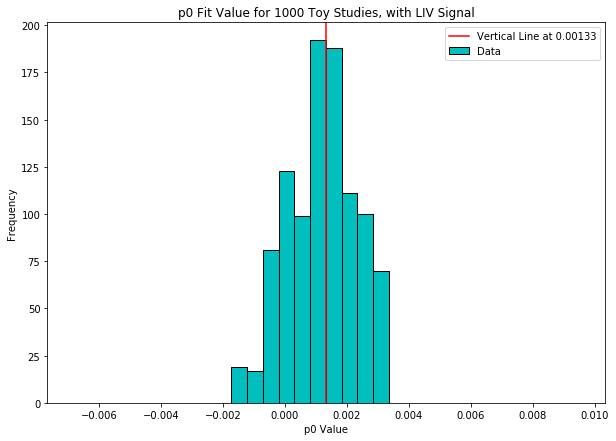

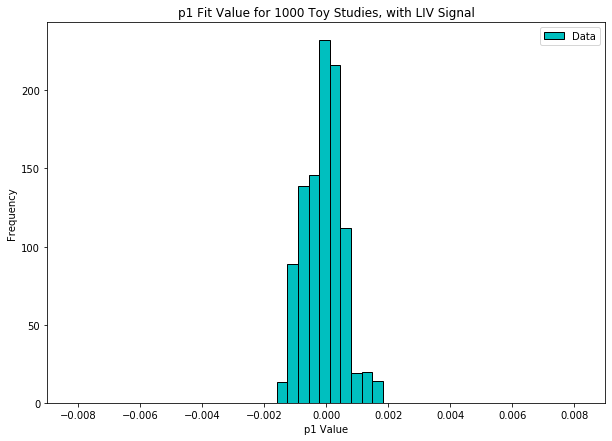

In [30]:

fig = plt.figure(figsize = (10, 7))
nBin = 10
plt.title('p0 Fit Value for 1000 Toy Studies, with LIV Signal')
plt.ylabel('Frequency')
plt.xlabel('p0 Value')
plt.hist(p0_Arr2,bins=nBin,color='c',edgecolor='black',linewidth=1,label='Data')
plt.axvline(x=1/750,label='Vertical Line at 0.00133',color='r')
plt.legend()
plt.xlim(1/750-xscale,1/750+xscale)
plt.savefig(r'thesis template\figures\LIVp0Values.png', dpi=300)



fig = plt.figure(figsize = (10, 7))
nBin = 10
plt.title('p1 Fit Value for 1000 Toy Studies, with LIV Signal')
plt.ylabel('Frequency')
plt.xlabel('p1 Value')
plt.hist(p1_Arr2,bins=nBin,color='c',edgecolor='black',linewidth=1,label='Data')
plt.legend()
plt.xlim(-xscale,xscale)
plt.savefig(r'thesis template\figures\LIVp1Values.png', dpi=300)

In [42]:
p0_Arr3,p1_Arr3,p0Err_Arr3,p1Err_Arr3,chi_pdf3 = Toys([2015,2016,2017,2018],SidDay = timedelta(hours=1),nToys = 1000,Variance = True,seed = 9919, Mode=1)
# One Hour day with LIV

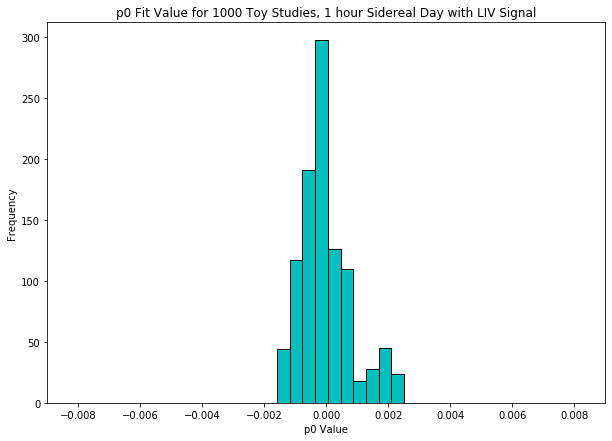

In [45]:

fig = plt.figure(figsize = (10, 7))
nBin = 10
plt.title('p0 Fit Value for 1000 Toy Studies, 1 hour Sidereal Day with LIV Signal')
plt.ylabel('Frequency')
plt.xlabel('p0 Value')
n, bins, rects = plt.hist(p0_Arr3s,bins=nBin,color='c',edgecolor='black',linewidth=1)
plt.xlim(-xscale,xscale)
plt.savefig(r'thesis template\figures\onehourp0Values.png', dpi=300)


fig = plt.figure(figsize = (10, 7))
nBin = 10
plt.title('p1 Fit Value for 1000 Toy Studies, 1 hour Sidereal Day with LIV Signal')
plt.ylabel('Frequency')
plt.xlabel('p1 Value')
n, bins, rects = plt.hist(p1_Arr3c,bins=nBin,color='c',edgecolor='black',linewidth=1)
plt.xlim(-xscale,xscale)
plt.savefig(r'thesis template\figures\onehourp1Values.png', dpi=300)

In [82]:
p0_bin = {}
p0Err_bin = {}
chi_bin = {}
m=150
for n in range (5,m+1):
    print(n)
    p0_Arr,p1_Arr,p0Err_Arr,p1Err_Arr,chi_pdf = Toys([2015,2016,2017,2018], nBins = n,nToys = 1,Variance = False,seed = 0, Mode=1)
    p0_bin[n] = np.array(p0_Arr)
    p0Err_bin[n] = np.array(p0Err_Arr)
    chi_bin[n] = chi_pdf



5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


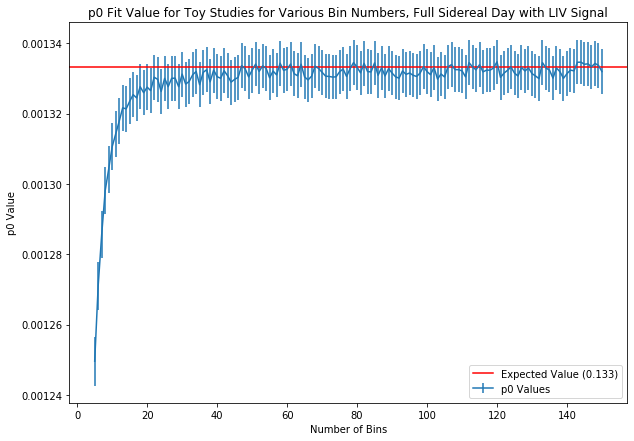

In [116]:
avrp0 = []
avrp0Err = []
for array in p0_bin:
    avrp0 += [np.mean(p0_bin[array])]
    avrp0Err += [np.mean(p0Err_bin[array])]
    

fig = plt.figure(figsize = (10, 7))
plt.title('p0 Fit Value for Toy Studies for Various Bin Numbers, Full Sidereal Day with LIV Signal')
plt.ylabel('p0 Value')
plt.xlabel('Number of Bins')
plt.axhline(y=1/750,color='r',label='Expected Value (0.133)')
plt.errorbar(np.linspace(5,m,m-4),np.array(avrp0),yerr = np.array(avrp0Err),label='p0 Values')
plt.legend(loc=4)
plt.savefig(r'thesis template\figures\fit_bins.png', dpi=300)
plt.show()

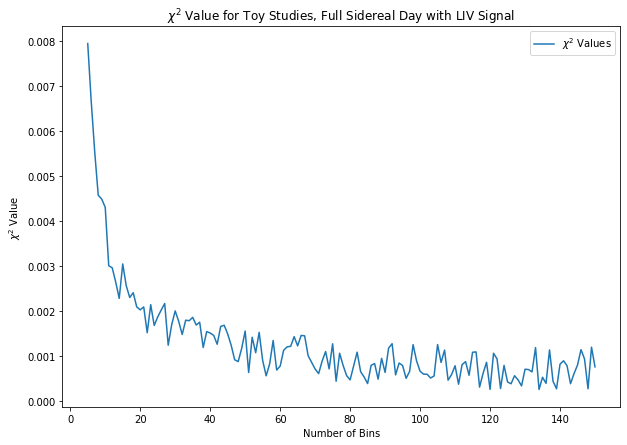

In [117]:
chis = []
for k in chi_bin:
    chis += [np.mean(chi_bin[k])]



fig = plt.figure(figsize = (10, 7))
plt.title('$\chi^2$ Value for Toy Studies, Full Sidereal Day with LIV Signal')
plt.ylabel('$\chi^2$ Value')
plt.xlabel('Number of Bins')
plt.plot(np.linspace(5,m,m-4),np.array(chis)+np.random.random(size=len(avrp0))/1000,label='$\chi^2$ Values')
plt.legend()
plt.savefig(r'thesis template\figures\fit_chi.png', dpi=300)
plt.show()